[toc] 

# Tensorflow CRF

函数讲解：

## tf.contrib.crf.crf_log_likelihood

```
crf_log_likelihood(inputs,tag_indices,sequence_lengths,transition_params=None)
```

在一个条件随机场里面计算标签序列的`log-likelihood`

参数:

- inputs: 一个形状为 `[batch_size, max_seq_len, num_tags]` 的tensor,一般使用BILSTM处理之后输出转换为他要求的形状作为CRF层的输入.
- tag_indices: 一个形状为 `[batch_size, max_seq_len]` 的矩阵,其实就是真实标签.
- sequence_lengths: 一个形状为 `[batch_size]` 的向量,表示每个序列的长度.
- transition_params: 形状为 `[num_tags, num_tags]` 的转移矩阵

返回：

- log_likelihood: [batch_size],log-likelihood
- transition_params: 形状为[num_tags, num_tags] 的转移矩阵

## tf.contrib.crf.viterbi_decode

```
viterbi_decode(score,transition_params)
```

通俗一点,作用就是返回最好的标签序列.这个函数只能够在测试时使用,在tensorflow外部解码

参数:

- score: 一个形状为 `[seq_len, num_tags]` matrix of unary potentials.
- transition_params: 形状为 `[num_tags, num_tags]` 的转移矩阵

返回：

- viterbi: 一个形状为 `[seq_len]` 显示了最高分的标签索引的列表.
- viterbi_score: A float containing the score for the Viterbi sequence.

## tf.contrib.crf.crf_decode

```
crf_decode(potentials,transition_params,sequence_length)
```

在tensorflow内解码，给一个 potentials，返回最好的序列标记

参数:

- potentials: 一个形状为[batch_size, max_seq_len, num_tags] 的tensor,
- transition_params: 一个形状为[num_tags, num_tags] 的转移矩阵
- sequence_length: 一个形状为[batch_size] 的 ,表示batch中每个序列的长度

返回：

- decode_tags:一个形状为[batch_size, max_seq_len] 的tensor,类型是tf.int32.表示最好的序列标记.
- best_score: 有个形状为[batch_size] 的tensor, 包含每个序列解码标签的分数.

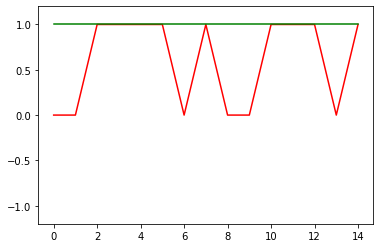

cost: 31.8787


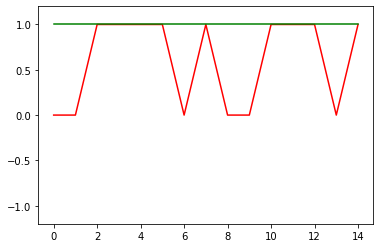

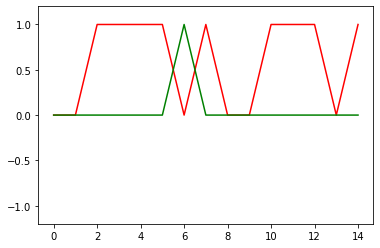

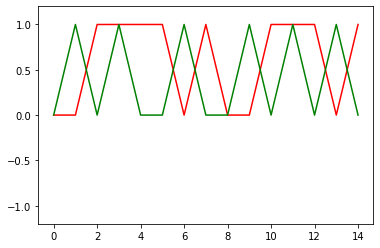

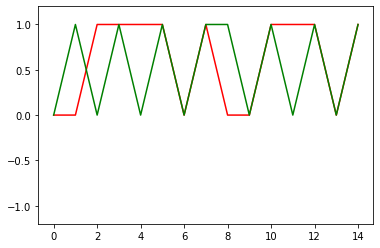

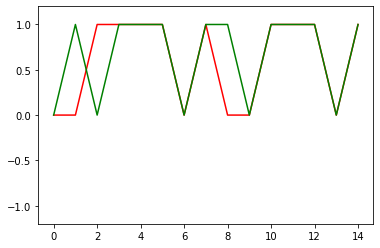

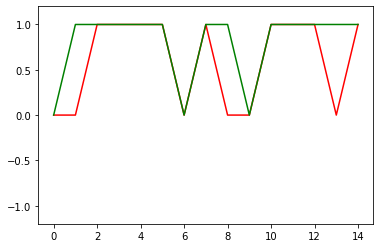

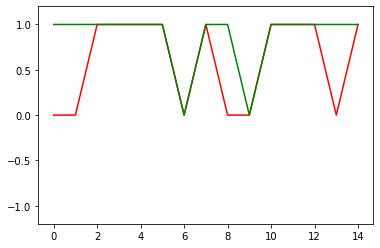

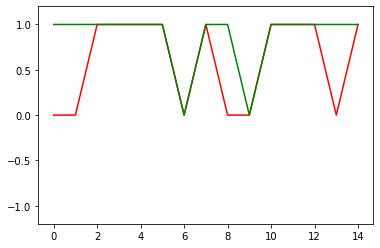

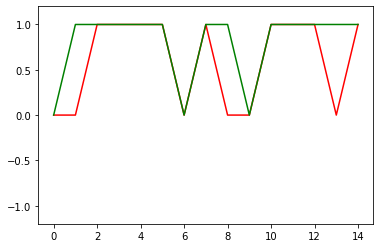

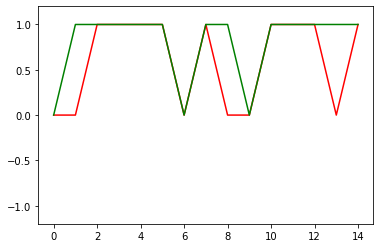

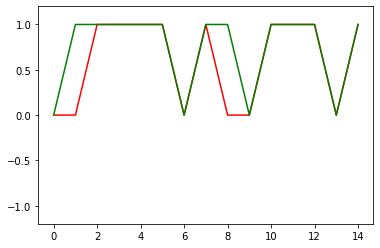

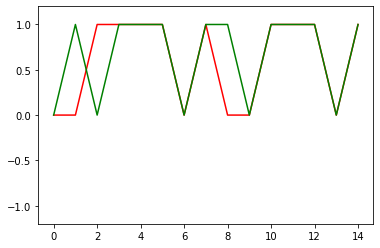

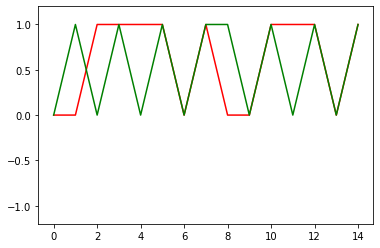

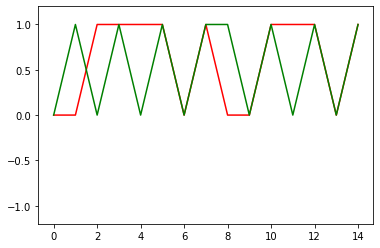

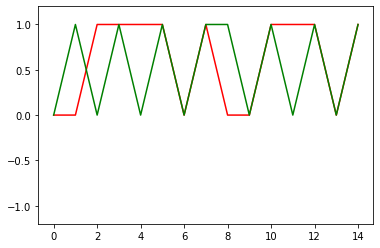

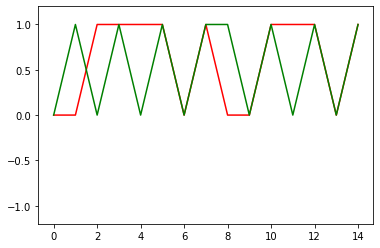

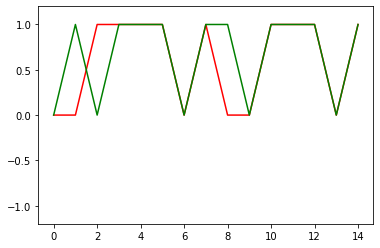

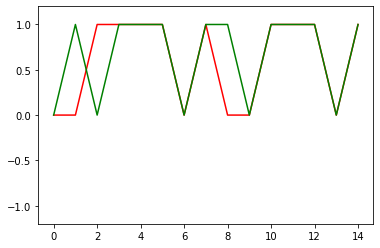

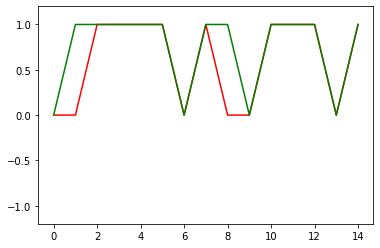

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()

Timestep = 15 # 输入的总长度，可以理解为15个rnn cell
Batchsize = 1 # 一次就输入一个
Inputsize = 1
LR = 0.5
num_tags = 2

#定义batch输出
def get_batch():
    xs = np.array([[2, 3, 4, 5, 5, 5, 1, 5, 3, 2, 5, 5, 5, 3, 5]])
    res = np.array([[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]])
    return [xs[:, :, np.newaxis], res]

# xs变成三维的 res还是二维的

class CRF:
    def __init__(self, time_steps, input_size, num_tags, batch_size):
        self.time_steps = time_steps
        self.input_size = input_size
        self.num_tags = num_tags
        self.batch_size = batch_size
        
        self.xs = tf.placeholder(tf.float32, [None, self.time_steps, self.input_size], name='xs')
        self.res = tf.placeholder(tf.int32, [self.batch_size, self.time_steps], name='res')#为什么和xs的定义模式不一样
        
        weights = tf.get_variable('weights', [self.input_size, self.num_tags])
        # matricized_xs = tf.reshape(self.xs, [-1, self.input_size])
        unary_scores = tf.matmul(self.xs, weights)
        # unary_scores = tf.reshape(matricized_unary_scores, [self.batch_size, self.time_steps, self.num_tags])
        # [T, T, T, T]
        sequence_len = np.full(self.batch_size, self.time_steps, dtype=np.int32)
        
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(unary_scores, self.res, sequence_len)
        self.pred, viterbiscore = tf.contrib.crf.crf_decode(unary_scores, transition_params, sequence_len)
        self.loss = tf.reduce_mean(-log_likelihood)
        self.train_op = tf.train.AdamOptimizer(LR).minimize(self.loss)
        
    def train_one_step(self, xs, res):
        feed_dict = {self.xs: xs,
                     self.res: res}
        _, cost, pred = sess.run([self.train_op, self.loss, self.pred],
                                 feed_dict=feed_dict)
        return cost, pred

if __name__ == '__main__':
    crf = CRF(Timestep, Inputsize, num_tags, Batchsize)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        plt.ion()#动态曲线
        plt.show()
        for i in range(20):
            xs, res = get_batch()
            cost, pred = crf.train_one_step(xs, res)
            x = xs.reshape(-1, 1)
            r = res.reshape(-1, 1)
            p = pred.reshape(-1, 1)
            x = range(len(x))
            plt.clf()
            plt.plot(x, r, 'r', x, p, 'g')
            plt.ylim(-1.2, 1.2)
            plt.draw()
            plt.pause(0.3)
            if i % 20 == 0:
                print('cost:', round(cost, 4))

In [4]:
import numpy as np
import tensorflow as tf

np.random.seed(123)

# data settings
num_examples = 10
num_words = 20
num_features = 100
num_tags = 5  # 5 tags

#x shape = [10,20,100]
#random features.
x = np.random.rand(num_examples, num_words, num_features).astype(np.float32)

#y shape = [10,20]
#Random tag indices representing the gold sequence.
y = np.random.randint(num_tags, size=[num_examples,
                                      num_words]).astype(np.int32)

#sequence_lengths = [19,19,19,19,19,19,19,19,19,19]
# 每个序列的有效长度。这里是模拟没有pad的输入，因此都是 num_words - 1
sequence_lengths = np.full(num_examples, num_words - 1, dtype=np.int32)

#Train and evaluate the model.
with tf.Graph().as_default():
    tf.random.set_random_seed(123)
    with tf.Session() as session:
        # Add the data to the TensorFlow gtaph.
        x_t = tf.constant(x)  # 观测序列
        y_t = tf.constant(y)  # 标记序列
        sequence_lengths_t = tf.constant(sequence_lengths)

        # Compute unary scores from a linear layer.
        # weights shape = [100,5]
        weights = tf.get_variable("weights", [num_features, num_tags])

        # matricized_x_t shape = [200,100]
#         matricized_x_t = tf.reshape(x_t, [-1, num_features])

        # compute  [200,100] * [100,5] -> [200,5]
        # 计算结果
        unary_scores = tf.matmul(x_t, weights)

        #  unary_scores shape = [batch_size, seq_len,num_tags]
#         unary_scores = tf.reshape(matricized_unary_scores,
#                                   [num_examples, num_words, num_tags])
        # compute the log-likelihood of the gold sequences and keep the transition
        # params for inference at test time.
        #   shape   [10,20,5]   [10,20]   [10]
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(
            unary_scores, y_t, sequence_lengths_t)

        # viterbi_sequence 就是输出的序列
        viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(
            unary_scores, transition_params, sequence_lengths_t)

        # add a training op to tune the parameters.
        loss = tf.reduce_mean(-log_likelihood)

        # 定义梯度下降算法的优化器
        train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        session.run(tf.global_variables_initializer())

        #这里用mask过滤掉不符合的结果
        mask = (np.expand_dims(np.arange(num_words), axis=0) < np.expand_dims(
            sequence_lengths, axis=1))

        ## mask = array([[ True,  True,  True,  True,  True,  True,  True,  True,  True, True]], dtype=bool)
        total_labels = np.sum(sequence_lengths)

        print("mask:", mask)

        print("total_labels:", total_labels)
        for i in range(1000):
            #tf_unary_scores,tf_transition_params,_ = session.run([unary_scores,transition_params,train_op])
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op])
            if i % 100 == 0:
                '''
                false*false = false  false*true= false ture*true = true
                '''
                #序列中预测对的个数
                correct_labels = np.sum((y == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Accuracy: %.2f%%" % accuracy)

mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True F

# References
1. [tensorflow笔记3：CRF函数：tf.contrib.crf.crf_log_likelihood() - 细雨微光 - 博客园](https://www.cnblogs.com/lovychen/p/8490397.html)